In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
import rioxarray as rxr
from matplotlib.patches import Rectangle
import logging
import xarray as xr
import dask.array as da
from dask_ml.decomposition import PCA
from dask_ml.cluster import KMeans
from dask.diagnostics import ProgressBar
from dask.distributed import Client

In [2]:
auth = earthaccess.login()
client = Client()

2025-08-05 19:39:38,047 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('rechunk-split-bc78822f0a079bce5f0b42399cb44792', 126) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: Alias(('rechunk-split-bc78822f0a079bce5f0b42399cb44792', 126)->('concatenate-getitem-open_dataset-rhos-rechunk-split-bc78822f0a079bce5f0b42399cb44792', 126))
new run_spec: <Task ('rechunk-split-bc78822f0a079bce5f0b42399cb44792', 126) getitem(...)>
old dependencies: {('concatenate-getitem-open_dataset-rhos-rechunk-split-bc78822f0a079bce5f0b42399cb44792', 126)}
new dependencies: frozenset({('getitem-7401ba13064ad1d8fdcb4df9a3e6

In [3]:
tspan = ("2025-02-01", "2025-03-01")
bbox = (123.084, -29.566, 138.024, -17.050)
res_rf = earthaccess.search_data(
    short_name="PACE_OCI_L3M_SFREFL",
    temporal=tspan,
    granule_name='*.MO.*0p1deg*',
    bounding_box=bbox
)
path_rf = earthaccess.open(res_rf)
ds_rf = xr.open_mfdataset(path_rf, combine="nested", concat_dim="date")
min_lon, max_lat, max_lon, min_lat = bbox
ds_rf = ds_rf.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))
ds_rf

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset> Size: 18MB
Dimensions:     (date: 2, lat: 126, lon: 149, wavelength: 122, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 976B 346.0 351.0 ... 2.131e+03 2.258e+03
  * lat         (lat) float32 504B -17.05 -17.15 -17.25 ... -29.35 -29.45 -29.55
  * lon         (lon) float32 596B 123.2 123.3 123.4 123.5 ... 137.8 137.9 138.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    rhos        (date, lat, lon, wavelength) float32 18MB dask.array<chunksize=(1, 2, 41, 8), meta=np.ndarray>
    palette     (date, rgb, eightbitcolor) uint8 2kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20250201_20250228.L3m.MO.SFRE...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/SFREFL/3.0
    data_bins:                         5325334
    data_minimum:                      -0.05000001
    data_maximum:                      1.0

In [4]:
dims_to_remove = {'rgb', 'eightbitcolor'}
vars_to_drop = [var for var in ds_rf.data_vars
                if dims_to_remove & set(ds_rf[var].dims)]
ds_rf = ds_rf.drop_vars(vars_to_drop)

In [5]:
# ----------------------------------------
# Setup logging
# ----------------------------------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = logging.getLogger()

# ----------------------------------------
# Begin preprocessing
# ----------------------------------------
log.info("Starting clustering pipeline...")

# Step 1: Chunk the dataset
log.info("Chunking dataset...")
chunked = ds_rf.chunk({'lat': 100, 'lon': 100})

# Step 2: Select variable and reshape
log.info("Stacking spatial dimensions and reshaping...")
stacked_da = chunked['rhos'].stack(samples=('lat', 'lon')).transpose('samples', 'date', 'wavelength')
X = stacked_da.data
X_flat = X.reshape((X.shape[0], -1))
log.info(f"Flattened data shape: {X_flat.shape}")

# Step 3: Rechunk
log.info("Rechunking to ensure one chunk along feature axis...")
X_flat = X_flat.rechunk({1: -1})

# Step 4: Fill NaNs
log.info("Filling NaNs with zeros...")
X_flat = da.where(da.isnan(X_flat), 0, X_flat)

# # Step 5: PCA
# log.info("Fitting PCA for dimensionality reduction...")
# pca = PCA(n_components=10)
# with ProgressBar():
#     X_reduced = pca.fit_transform(X_flat)
#     X_reduced.compute_chunk_sizes()
# log.info(f"PCA reduced shape: {X_reduced.shape}")
X_reduced = X_flat
# Step 6: KMeans
log.info("Fitting KMeans clustering...")
kmeans = KMeans(n_clusters=15, init_max_iter=5, max_iter=1, oversampling_factor=10, random_state=0)
with ProgressBar():
    kmeans.fit(X_reduced)
log.info("KMeans clustering complete.")

# Step 7: Convert labels back to spatial grid
log.info("Converting labels to xarray...")
labels = kmeans.labels_
labels_xr = xr.DataArray(labels, coords={'samples': stacked_da['samples']}, dims='samples')
labels_2d = labels_xr.unstack('samples')

log.info("Clustering pipeline complete.")

2025-08-05 19:37:22,148 - INFO - Starting clustering pipeline...
2025-08-05 19:37:22,149 - INFO - Chunking dataset...
2025-08-05 19:37:22,161 - INFO - Stacking spatial dimensions and reshaping...
2025-08-05 19:37:22,178 - INFO - Flattened data shape: (18774, 244)
2025-08-05 19:37:22,179 - INFO - Rechunking to ensure one chunk along feature axis...
2025-08-05 19:37:22,180 - INFO - Filling NaNs with zeros...
2025-08-05 19:37:22,183 - INFO - Fitting KMeans clustering...
2025-08-05 19:37:22,184 - INFO - Starting _check_array
2025-08-05 19:38:34,403 - INFO - Finished _check_array in 0:01:12.219255
2025-08-05 19:38:34,410 - INFO - Starting init_scalable
2025-08-05 19:38:34,441 - INFO - Initializing with k-means||
2025-08-05 19:40:46,847 - INFO - Starting init iteration  1/ 1 ,  1 centers
2025-08-05 19:41:53,496 - INFO - Finished init iteration  1/ 1 ,  1 centers in 0:01:06.649001
2025-08-05 19:43:03,254 - WARNING - Found fewer than 15 clusters in init (found 11).
2025-08-05 19:44:10,987 - IN

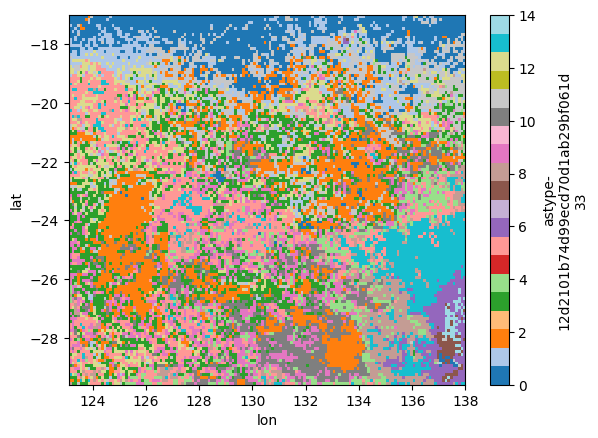

In [9]:
# labels_2d_local = labels_2d.compute()
labels_2d_local.plot.imshow(cmap='tab20')

In [ ]:
plt.figure(figsize=(8, 6))
labels_2d.plot.imshow(cmap='tab10', add_colorbar=True)
plt.title("K-Means Clustering")
plt.savefig("kmeans_clusters.png", dpi=300, bbox_inches='tight')
plt.close()